In [2]:
import pandas as pd
import numpy as np
import ast
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

In [53]:
import xgboost as xgb
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import scikitplot as skplt

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
train_labels = pd.read_csv('train_labels.csv', sep=';')
test = pd.read_csv('test.csv', sep=';')
referer_vectors = pd.read_csv('referer_vectors.csv', sep=';')
train = pd.read_csv('train.csv', sep=';')
test_users = pd.read_csv('test_users.csv', sep=';')
geo_info = pd.read_csv('geo_info.csv', sep=';')

In [5]:
train_labels.shape, train.shape, test.shape

((500000, 2), (750000, 5), (150000, 5))

In [6]:
train_labels.user_id.nunique(), train.user_id.nunique(), test.user_id.nunique()

(500000, 655672, 131998)

In [7]:
train.user_agent[0]

"{'browser': 'Chrome Mobile', 'browser_version': '119.0.0', 'os': 'Android', 'os_version': '10'}"

In [8]:
df = train.copy()

In [9]:
df.user_agent = df.user_agent.fillna('{}')

In [10]:
df.user_agent = df.user_agent.apply(ast.literal_eval)

In [11]:
df = df.merge(referer_vectors, how='left', on='referer')

In [12]:
df = df.merge(geo_info, how='left', on='geo_id')

In [13]:
df['browser'] = df.user_agent.apply(lambda x: x.get('browser', 'undefined'))
df['browser_version'] = df.user_agent.apply(lambda x: x.get('browser_version', 'undefined'))
df['os'] = df.user_agent.apply(lambda x: x.get('os', 'undefined'))
df['os_version'] = df.user_agent.apply(lambda x: x.get('os_version', 'undefined'))

In [14]:
df = df.merge(train_labels, how='left', on='user_id')

In [15]:
df['request_datetime'] = pd.to_datetime(df.request_ts, unit='s')

In [16]:
df['year'] = df.request_datetime.dt.year
df['month'] = df.request_datetime.dt.month
df['day'] = df.request_datetime.dt.day
df['hour'] = df.request_datetime.dt.hour
df['minute'] = df.request_datetime.dt.minute

In [17]:
df.columns

Index(['request_ts', 'user_id', 'referer', 'geo_id', 'user_agent',
       'component0', 'component1', 'component2', 'component3', 'component4',
       'component5', 'component6', 'component7', 'component8', 'component9',
       'country_id', 'region_id', 'timezone_id', 'browser', 'browser_version',
       'os', 'os_version', 'target', 'request_datetime', 'year', 'month',
       'day', 'hour', 'minute'],
      dtype='object')

In [18]:
df.dtypes

request_ts                   int64
user_id                     object
referer                     object
geo_id                       int64
user_agent                  object
component0                   int64
component1                   int64
component2                   int64
component3                   int64
component4                   int64
component5                   int64
component6                   int64
component7                   int64
component8                   int64
component9                   int64
country_id                  object
region_id                   object
timezone_id                 object
browser                     object
browser_version             object
os                          object
os_version                  object
target                     float64
request_datetime    datetime64[ns]
year                         int64
month                        int64
day                          int64
hour                         int64
minute              

In [19]:
df.shape, df[df.target.isnull()].shape

((759972, 29), (158682, 29))

In [20]:
df = df.drop(columns='user_agent').drop_duplicates()

In [21]:
df = df[df.target.notnull()]

In [22]:
df.shape

(591836, 28)

In [23]:
df.columns

Index(['request_ts', 'user_id', 'referer', 'geo_id', 'component0',
       'component1', 'component2', 'component3', 'component4', 'component5',
       'component6', 'component7', 'component8', 'component9', 'country_id',
       'region_id', 'timezone_id', 'browser', 'browser_version', 'os',
       'os_version', 'target', 'request_datetime', 'year', 'month', 'day',
       'hour', 'minute'],
      dtype='object')

In [24]:
# df = pd.get_dummies(df, columns=['country_id','region_id','timezone_id','browser','os','os_version'], drop_first=True )

In [25]:

encoder = OrdinalEncoder()
df[['country_id','region_id','timezone_id','browser','browser_version','os','os_version']] = encoder.fit_transform(df[['country_id','region_id','timezone_id','browser','browser_version','os','os_version']])

In [26]:
train_users, val_users = train_test_split( df.user_id, test_size=0.2, random_state=42)


In [27]:
X_train = df[df.user_id.isin(train_users)][['component0', 'component1', 'component2', 'component3', 'component4',
       'component5', 'component6', 'component7', 'component8', 'component9',
       'country_id', 'region_id', 'timezone_id', 'browser', 'browser_version',
       'os', 'os_version','hour']]
y_train = df[df.user_id.isin(train_users)]['target']
X_val = df[df.user_id.isin(val_users)][['component0', 'component1', 'component2', 'component3', 'component4',
       'component5', 'component6', 'component7', 'component8', 'component9',
       'country_id', 'region_id', 'timezone_id', 'browser', 'browser_version',
       'os', 'os_version','hour']]
y_val = df[df.user_id.isin(val_users)]['target']

In [28]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [29]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((501952, 18), (501952,), (151076, 18), (151076,))

In [31]:
D_train = xgb.DMatrix(X_train_scaled, label=y_train)
D_val = xgb.DMatrix(X_val_scaled, label=y_val)

In [32]:
param = {
'eta': 0.3,
'max_depth': 20,
'objective': 'multi:softprob',
'num_class': 18}

steps = 20

In [33]:
model = xgb.train(param, D_train, steps)
preds = model.predict(D_val)
best_preds = np.asarray([np.argmax(line) for line in preds])

In [34]:
print("precision_score: {}".format(precision_score(y_val, best_preds, average='macro')))
print("recall_score: {}".format(recall_score(y_val, best_preds, average='macro')))
print("accuracy_score: {}".format(accuracy_score(y_val, best_preds)))
print("f1_score: {}".format(f1_score(y_val, best_preds)))
print("roc_auc_score: {}".format(roc_auc_score(y_val, best_preds)))

precision_score: 0.8685880872721967
recall_score: 0.868119623930363
accuracy_score: 0.868576080912918
f1_score: 0.8623942227058196
roc_auc_score: 0.868119623930363


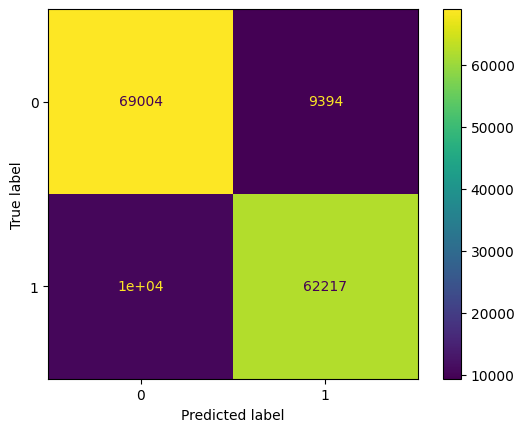

In [42]:
disp=ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_val, best_preds))
disp.plot()

In [54]:
fpr, tpr, thresholds = roc_curve(y_val, best_preds)
roc_auc = auc(fpr, tpr)

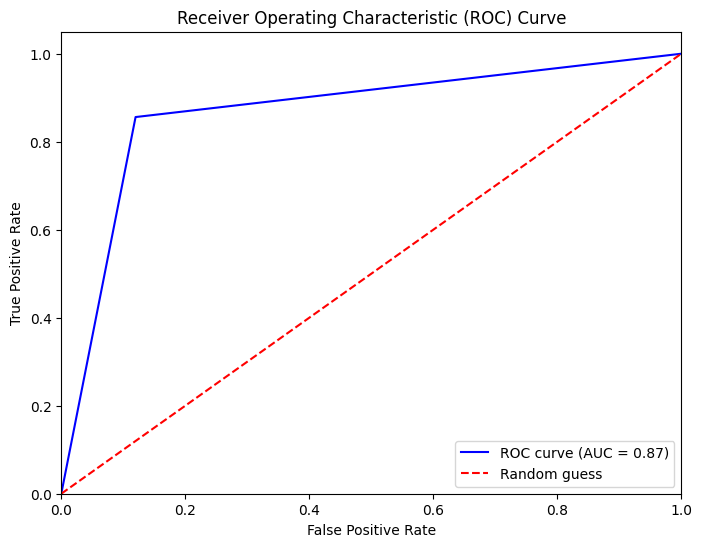

In [55]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

<Axes: >

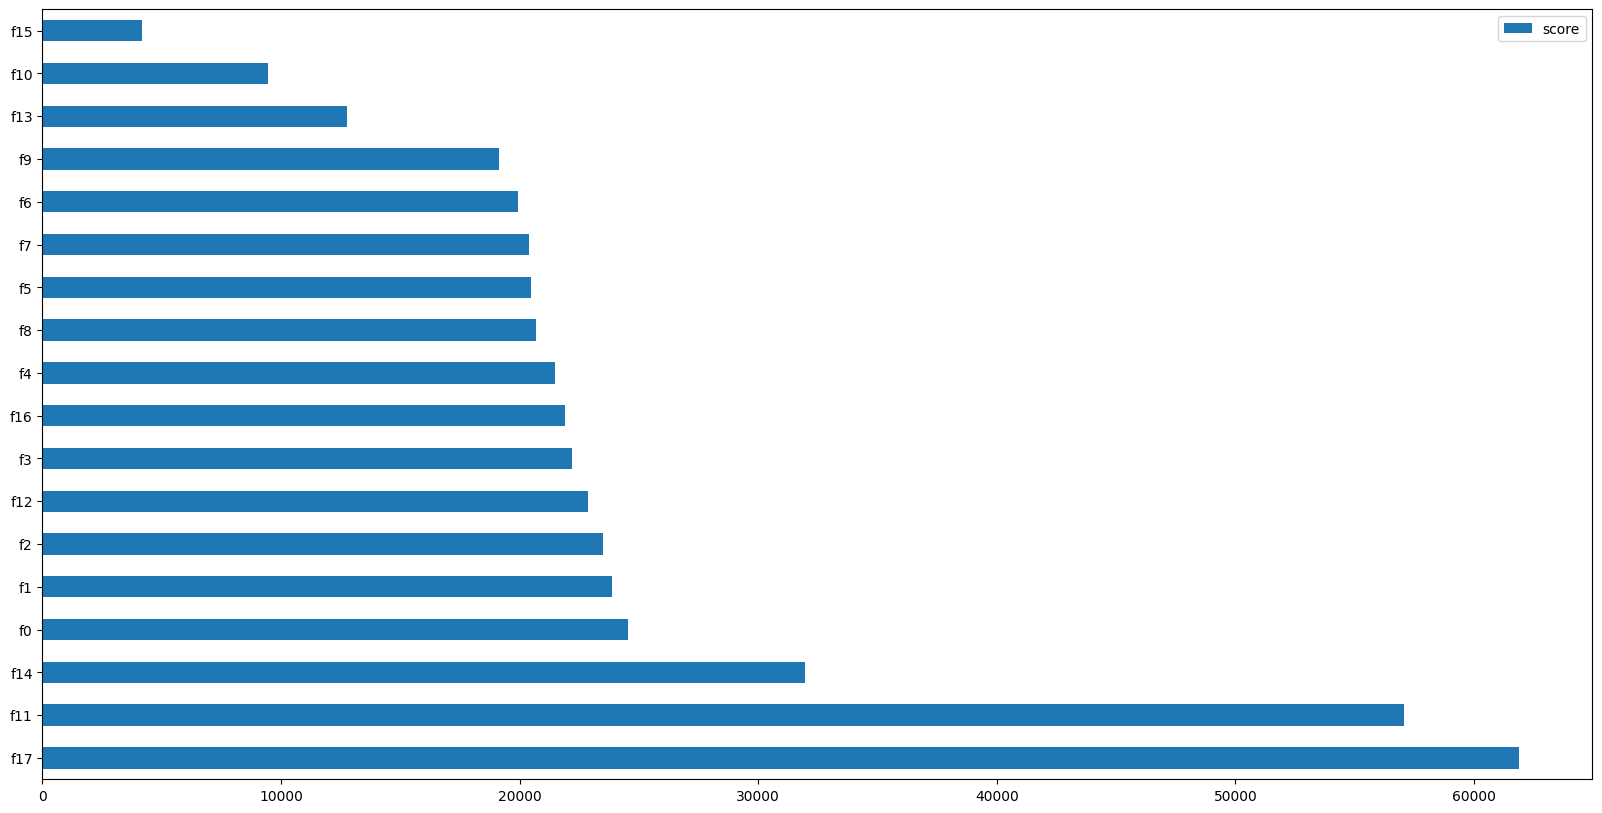

In [60]:
feature_important = model.get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(40, columns="score").plot(kind='barh', figsize = (20,10)) ## plot top 40 features

In [56]:
space = {
    'eta': hp.uniform('eta', 0.01, 0.3),
    'max_depth': hp.randint('max_depth', 15, 30),
    # 'min_child_weight': hp.randint('min_child_weight', 1, 10),
    # 'subsample': hp.uniform('subsample', 0.5, 1.0),
    # 'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    # 'gamma': hp.uniform('gamma', 0, 5),
    # 'n_estimators': hp.choice('n_estimators', [30, 50, 70, 100, 150]),
    # 'scale_pos_weight': hp.uniform('scale_pos_weight', 1, 10),
    'objective': 'multi:softprob',
    'num_class': 18
}

In [57]:
def objective(params):
    model = xgb.train(params, dtrain=D_train, num_boost_round=steps)
    preds = model.predict(D_val)
    best_preds = np.asarray([np.argmax(line) for line in preds])
    score = roc_auc_score(y_val, best_preds)
    return score

In [58]:
trials = Trials()
best = fmin(objective, space, algo=tpe.suggest, max_evals=100, trials=trials)

100%|████████████████████████████████████████████| 100/100 [1:43:29<00:00, 62.09s/trial, best loss: 0.8126184661770892]


In [63]:
# Получаем лучшие значения гиперпараметров
final_best_params = {}
for key in best:
    try:
        final_best_params[key] = dict_of_params[key][best[key]]
    except:
        final_best_params[key] = best[key]
